In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

## 5. Data Preprocessing

In [2]:
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
num_features = ['age', 'duration', 'campaign', 'pdays', 'previous', 'cons.price.idx', 'cons.conf.idx', 'nr.employed']

#### 5.1 Train - Test split

In [5]:
# data.to_csv('data.csv')

In [3]:
data = pd.read_csv('data.csv')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('y', axis=1), data.y.values, stratify=data.y, test_size=0.2, random_state=10)

print("Train data shape: ", X_train.shape, y_train.shape)
print("Test data shape: ",X_test.shape, y_test.shape)

Train data shape:  (32592, 19) (32592,)
Test data shape:  (8148, 19) (8148,)


#### 5.2 Data transformation

##### 5.2.1 Numerical features scaling

In [6]:
scaler = StandardScaler()
scaler = scaler.fit(data[num_features])

In [7]:
# creating new empty dataframes to store processed data for training
X_train_processed = X_train.drop(cat_features, axis=1)
X_test_processed = X_test.drop(cat_features, axis=1)
X_train_processed.columns

Index(['Unnamed: 0', 'age', 'duration', 'campaign', 'pdays', 'previous',
       'cons.price.idx', 'cons.conf.idx', 'nr.employed'],
      dtype='object')

In [8]:
X_train_processed.reset_index(drop=True, inplace=True)
X_test_processed.reset_index(drop=True, inplace=True)

In [9]:
# transform all numerical features and save it new dataframes
X_train_processed[num_features] = scaler.transform(X_train[num_features])
X_test_processed[num_features] = scaler.transform(X_test[num_features])

##### 5.2.2 Categorical feature tranformation

* We will tranform categorical features using onehot encoder

In [10]:
onehotencoder = OneHotEncoder(handle_unknown='ignore')
cat_features_ohe = onehotencoder.fit(X_train[cat_features])

In [11]:
X_train_ohe = cat_features_ohe.transform(X_train[cat_features])
X_test_ohe = cat_features_ohe.transform(X_test[cat_features])

In [12]:
X_train_ohe.toarray().shape

(32592, 52)

In [13]:
cat_feature_labels_ohe = np.concatenate(cat_features_ohe.categories_).ravel().tolist()

In [14]:
X_train_ohe = pd.DataFrame(X_train_ohe.toarray(), columns=cat_feature_labels_ohe)
X_test_ohe = pd.DataFrame(X_test_ohe.toarray(), columns=cat_feature_labels_ohe)

In [15]:
print("shape of categorical features of train and test sets after converting categorical features with one hot encoding:")
X_train_ohe.shape, X_test_ohe.shape

shape of categorical features of train and test sets after converting categorical features with one hot encoding:


((32592, 52), (8148, 52))

##### 5.2.3 Merging transformed numerical features and categorical features

In [16]:
X_train_final = pd.concat([X_train_ohe, X_train_processed], axis=1)
X_test_final = pd.concat([X_test_ohe, X_test_processed], axis=1)

X_train_final.drop('Unnamed: 0', axis=1, inplace=True)
X_test_final.drop('Unnamed: 0', axis=1, inplace=True)

print("Final processed train data and test data shapes: ")
print(X_train_final.shape, X_test_final.shape)

Final processed train data and test data shapes: 
(32592, 61) (8148, 61)


In [125]:
# X_train_final.to_csv('X_train_final.csv') #, index=False
# X_test_final.to_csv('X_test_final.csv') #, index=False

## 6. Modeling

In [18]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import confusion_matrix
from scikitplot.metrics import plot_cumulative_gain

In [19]:
def print_confusion_matrix_accuracy(model, X_test, y_true):
    # print confusion matrix
    y_pred = model.predict(X_test)
    confusion_matrix_test = confusion_matrix(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix_test.flatten()
    accuracy = (tp + tn)/ (tn + fp + fn + tp)
    print("Model Accuracy: ", accuracy)
    
    # code reference - https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    confusion_matrix_test.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         confusion_matrix_test.flatten()/np.sum(confusion_matrix_test)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(confusion_matrix_test, annot=labels, fmt='', cmap='Greens')
    plt.title("Confusion Matrix for Test Data")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
        
    return y_pred, accuracy


In [20]:
def plot_auc(model, X_train, X_test, y_train, y_test):
    # AUC
    y_train_pred_prob = model.predict_proba(X_train) # taking only predictions for positive class
    y_test_pred_prob = model.predict_proba(X_test) # taking only predictions for positive class

    train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred_prob[:, 1])
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred_prob[:, 1])

    plt.plot(train_fpr, train_tpr, label='Train AUC:'+str(auc(train_fpr, train_tpr)))
    plt.plot(test_fpr, test_tpr, label='Test AUC:'+str(auc(test_fpr, test_tpr)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC curve for train and test sets')
    plt.legend()
    plt.grid()
    plt.show()

    return y_train_pred_prob, y_test_pred_prob, auc(test_fpr, test_tpr)

In [21]:
def precision_recall_f1(y_test, y_pred):
    precision, recall, f1_beta, support = precision_recall_fscore_support(y_test, y_pred) #, average='micro'
    print('Precision Score for class-0:', precision[0], 'and class-1: ', precision[1])
    print('-'*100)
    print('Recall Score for class-0:', recall[0], 'and class-1:', recall[1])
    print('-'*100)
    print('F1 Score for class-0:', f1_beta[0], 'and class-1:', f1_beta[1])
    # print('Support: ', support)
    return precision, recall, f1_beta

In [22]:
def plot_gain_curve(y_true, y_pred_prob, x, y):
    plot_cumulative_gain(y_true, y_pred_prob)
    plt.vlines(x=x, ymax=1, ymin=0, colors='g', linestyles='--')
    plt.hlines(y=y, xmax=0.9, xmin=0, colors='g', linestyles='--')
    # plt.grid()
    plt.show()
    
    # plot_lift_curve(y_test, y_test_pred_prob)

In [23]:
def get_lift_index(y_true, y_pred_prob):
    decile_df = pd.DataFrame(list(zip(y_true, y_pred_prob[:, 1])), columns=['y_true','y_pred'])
    decile_df['decile'] = pd.qcut(decile_df.y_pred, 10, duplicates='drop') #, duplicates='drop'  labels=np.arange(10,0,-1),
    lift_df = decile_df.groupby('decile')['y_pred'].count().reset_index()
    lift_df.rename({'y_pred':'total'}, axis=1, inplace=True)
    lift_df_pred = decile_df[decile_df.y_true==1].groupby('decile')['y_true'].count().reset_index()
    lift_df_final = lift_df.merge(lift_df_pred, on='decile')
    lift_df_final = lift_df_final.sort_values(['decile'], ascending=False)

    lift_df_final['decile'] = [(i+1) for i in range(len(lift_df_final.decile.unique()))]
    
    # calculate the weighted lift index value
    w = 1 # initializing the weight to 1
    lift_index = 0.0
    for cnt in lift_df_final.y_true.values:
        lift_index += cnt * w
        w = w - 0.1
    
    lift_index = lift_index/lift_df_final.y_true.sum()
    return lift_index

In [24]:
metrics = dict()

### 6.1 Logistic Regression

In [45]:
lr = LogisticRegression(random_state=10, class_weight='balanced', max_iter=1000) #, max_iter=500

model = lr.fit(X_train_final, y_train)

##### 6.1.1 Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.8602110947471773


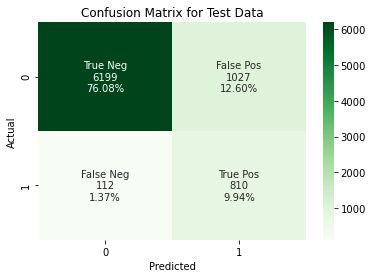

In [46]:
y_test_pred, acc = print_confusion_matrix_accuracy(model, X_test_final, y_test)

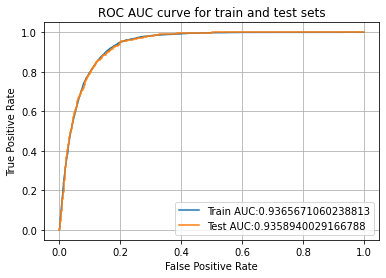

In [47]:
y_train_pred_prob, y_test_pred_prob, roc_auc = plot_auc(model, X_train_final, X_test_final, y_train, y_test)

In [48]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.9822532086832515 and class-1:  0.4409363091997823
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.8578743426515362 and class-1: 0.8785249457700651
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.9158602349117235 and class-1: 0.5871692642261689


In [50]:
lift_index = get_lift_index(y_test, y_test_pred_prob)
lift_index

0.9323210412147503

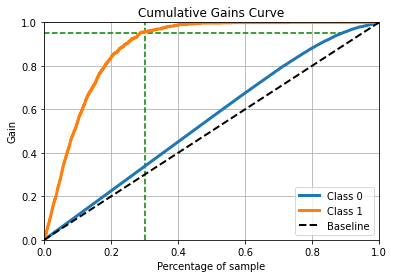

In [52]:
plot_gain_curve(y_test, y_test_pred_prob, 0.3, 0.95)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 30% of the leads we can acheive 95% of the conversion rate.

In [53]:
metrics['LR'] = dict()
metrics['LR']['accuracy'] = acc
metrics['LR']['auc'] = roc_auc
metrics['LR']['prec'] = prec
metrics['LR']['recal'] = rec
metrics['LR']['f1'] = f1
metrics['LR']['lift'] = lift_index

##### The below snippet is taken to cross check whether the above cumulative gain plot is giving the same result as this gain curve

In [41]:
# decile_df = pd.DataFrame(list(zip(np.hstack((y_train,y_test)), np.hstack((y_train_pred_prob[:, 1],y_test_pred_prob[:, 1])))), columns=['y_true','y_pred'])
decile_df = pd.DataFrame(list(zip(y_test, y_test_pred_prob[:, 1])), columns=['y_true','y_pred'])

In [110]:
# this piece of code taken from 
# https://medium.com/the-innovation/lead-conversion-score-prediction-using-python-a65d5bb7ccff
# to learn and understand the concept of lift curve analysis


decile_df['decile'] = pd.qcut(decile_df.y_pred, 10) #, labels=np.arange(10,0,-1)

lift_df = decile_df.groupby('decile')['y_pred'].count().reset_index()

lift_df.rename({'y_pred':'total'}, axis=1, inplace=True)

lift_df_pred = decile_df[decile_df.y_true==1].groupby('decile')['y_true'].count().reset_index()

lift_df_final = lift_df.merge(lift_df_pred, on='decile')

lift_df_final = lift_df_final.sort_values(['decile'], ascending=False)

lift_df_final['decile'] = [(i+1) for i in range(len(lift_df_final.decile.unique()))]

lift_df_final['cumresp'] = lift_df_final.y_true.cumsum()

lift_df_final['gain'] = (lift_df_final['cumresp']/sum(lift_df_final['y_true'])) * 100

lift_df_final['cumlift'] = lift_df_final['gain']/(lift_df_final['decile'].astype('int') * (100/10))

In [111]:
lift_df_final

,decile,total,y_true,cumresp,gain,cumlift
9,1,815,519,519,56.290672,5.629067
8,2,815,249,768,83.297180,4.164859
7,3,815,104,872,94.577007,3.152567
6,4,814,28,900,97.613883,2.440347
5,5,815,12,912,98.915401,1.978308
4,6,815,6,918,99.566161,1.659436
3,7,814,2,920,99.783080,1.425473
2,8,815,0,920,99.783080,1.247289
1,9,815,2,922,100.000000,1.111111
0,10,815,0,922,100.000000,1.000000


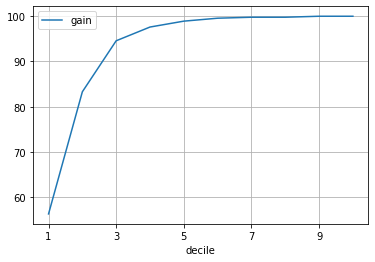

In [93]:
lift_df_final.plot.line(x='decile', y='gain')
plt.grid()
plt.show()

* The above curve also showing the same gain rate as the cumulative curve which was drwan using scikit-plot

### 6.2 Naive Bayes

In [54]:
gnb_clf = GaussianNB()

gnb_clf.fit(X_train_final, y_train)

GaussianNB()

#### 6.2.1 Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.8718703976435935


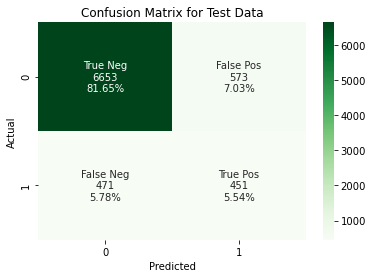

In [55]:
y_test_pred, acc = print_confusion_matrix_accuracy(gnb_clf, X_test_final, y_test)

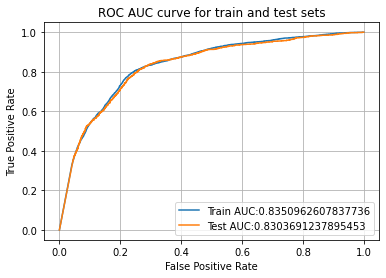

In [56]:
y_train_pred_prob, y_test_pred_prob, roc_auc = plot_auc(gnb_clf, X_train_final, X_test_final, y_train, y_test)

In [57]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.9338854576080854 and class-1:  0.4404296875
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.9207030168834763 and class-1: 0.4891540130151844
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.927247386759582 and class-1: 0.46351490236382326


In [58]:
lift_index = get_lift_index(y_test, y_test_pred_prob)

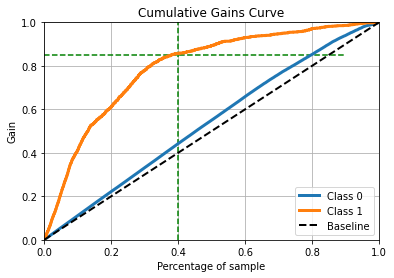

In [59]:
plot_gain_curve(y_test, y_test_pred_prob, x=0.4, y=0.85)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 40% of the leads we can acheive 85% of the conversion rate.

In [60]:
metrics['NB'] = dict()
metrics['NB']['accuracy'] = acc
metrics['NB']['auc'] = roc_auc
metrics['NB']['prec'] = prec
metrics['NB']['recal'] = rec
metrics['NB']['f1'] = f1
metrics['NB']['lift'] = lift_index

### 6.3 SVM

#### 6.3.1 SVC with RBF kernel

In [26]:
svc_clf = SVC(probability=True, class_weight='balanced', random_state=10)

svc_clf.fit(X_train_final, y_train)

SVC(class_weight='balanced', probability=True, random_state=10)

##### 6.3.1.1 Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.8518654884634266


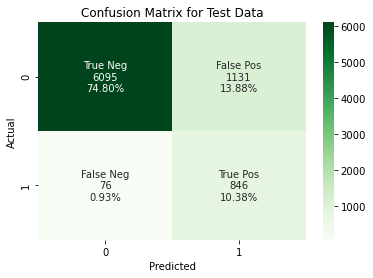

In [66]:
y_test_pred, acc = print_confusion_matrix_accuracy(svc_clf, X_test_final, y_test)

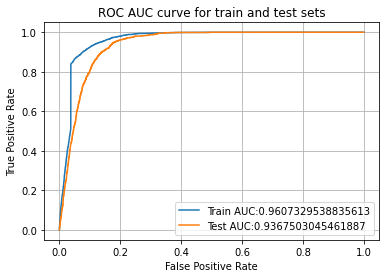

In [68]:
y_train_pred_prob, y_test_pred_prob, roc_auc = plot_auc(svc_clf, X_train_final, X_test_final, y_train, y_test)

In [69]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.9876843299303192 and class-1:  0.4279210925644917
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.8434818710213119 and class-1: 0.9175704989154013
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.9099052026573113 and class-1: 0.58364953432218


In [70]:
lift_index = get_lift_index(y_test, y_test_pred_prob)
lift_index

0.9330802603036876

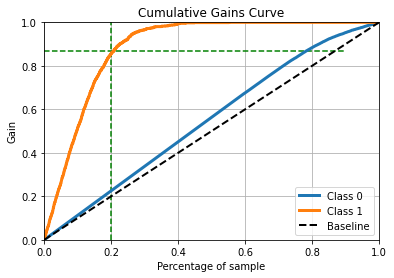

In [71]:
plot_gain_curve(y_test, y_test_pred_prob, x=0.2, y=0.87)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 20% of the leads we can acheive 87% of the conversion rate.

In [72]:
metrics['SVC'] = dict()
metrics['SVC']['accuracy'] = acc
metrics['SVC']['auc'] = roc_auc
metrics['SVC']['prec'] = prec
metrics['SVC']['recal'] = rec
metrics['SVC']['f1'] = f1
metrics['SVC']['lift'] = lift_index

### 6.4 Decision Tree Classifier

In [88]:
# max_depth, min_samples_split, min_samples_leaf
params = {'max_depth': [3, 4, 5, 6, 7, 8, 9], 'min_samples_split': [2, 3, 4, 5], 'criterion': ['gini', 'entropy']}

dt_clf = DecisionTreeClassifier(class_weight='balanced', random_state=10)

grid_CV = GridSearchCV(dt_clf, params, scoring='f1', cv=5, verbose=4, n_jobs=-1)
grid_CV.fit(X_train_final, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=10),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': [2, 3, 4, 5]},
             scoring='f1', verbose=4)

In [89]:
print('Best F1 score for Decision Tree: ', grid_CV.best_score_)
print('Best Params for Decision Tree: ', grid_CV.best_params_)

Best F1 score for Decision Tree:  0.5700317833373152
Best Params for Decision Tree:  {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 4}


In [74]:
dt_clf = DecisionTreeClassifier(criterion='entropy', 
                                    max_depth=6, 
                                    min_samples_split=4,
                                    class_weight='balanced', random_state=10)

dt_clf.fit(X_train_final, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=6, min_samples_split=4, random_state=10)

##### 6.4.1 Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.850392734413353


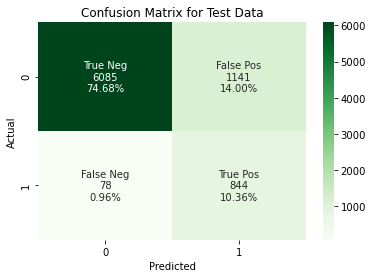

In [75]:
y_test_pred, acc = print_confusion_matrix_accuracy(dt_clf, X_test_final, y_test)

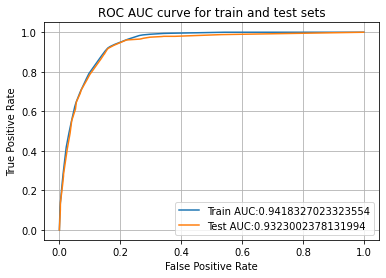

In [76]:
y_train_pred_prob, y_test_pred_prob, roc_auc = plot_auc(dt_clf, X_train_final, X_test_final, y_train, y_test)

In [77]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.9873438260587376 and class-1:  0.4251889168765743
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.8420979795184057 and class-1: 0.9154013015184381
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.9089551124057061 and class-1: 0.5806673546611627


In [78]:
lift_index = get_lift_index(y_test, y_test_pred_prob)

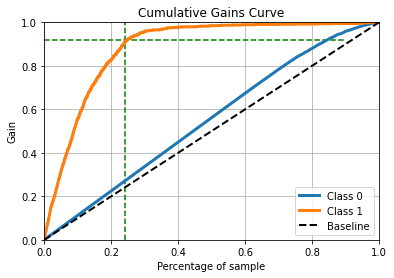

In [80]:
plot_gain_curve(y_test, y_test_pred_prob, x=0.24, y=0.92)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 22% of the leads we can acheive 92% of the conversion rate.

In [81]:
metrics['DT'] = dict()
metrics['DT']['accuracy'] = acc
metrics['DT']['auc'] = roc_auc
metrics['DT']['prec'] = prec
metrics['DT']['recal'] = rec
metrics['DT']['f1'] = f1
metrics['DT']['lift'] = lift_index

#### 6.5 Random Forest Classifier

In [126]:
# max_depth, min_samples_split, min_samples_leaf
params = {'n_estimators':[100, 200, 300, 400], 'max_depth': [3, 4, 5, 6, 7, 8, 9], 
          'min_samples_split': [2, 3, 4, 5], 'criterion': ['gini', 'entropy']}

rf_clf = RandomForestClassifier(class_weight='balanced', random_state=10)

grid_rf_CV = GridSearchCV(rf_clf, params, scoring='f1', cv=5, verbose=4, n_jobs=-1)
grid_rf_CV.fit(X_train_final, y_train)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=10),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='f1', verbose=4)

In [147]:
print('Best F1 score for Random Forest: ', grid_rf_CV.best_score_)
print('Best Params for Random Forest: ', grid_rf_CV.best_params_)

Best F1 score for Random Forest:  0.5921692249540895
Best Params for Random Forest:  {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 3, 'n_estimators': 100}


In [82]:
rf_clf = RandomForestClassifier(n_estimators=100, 
                                criterion='gini', 
                                max_depth=9, 
                                min_samples_split=3,
                                class_weight='balanced',
                                random_state=10)

rf_clf.fit(X_train_final, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=9,
                       min_samples_split=3, random_state=10)

##### 6.5.1 Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.8592292587137947


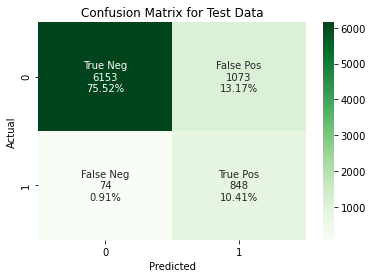

In [83]:
y_test_pred, acc = print_confusion_matrix_accuracy(rf_clf, X_test_final, y_test)

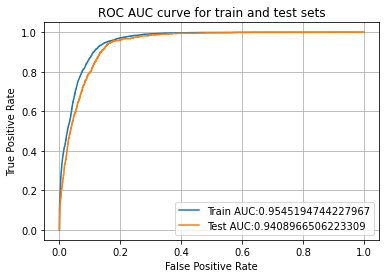

In [84]:
y_train_pred_prob, y_test_pred_prob, roc_auc = plot_auc(rf_clf, X_train_final, X_test_final, y_train, y_test)

In [85]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.9881162678657459 and class-1:  0.44143675169182717
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.8515084417381678 and class-1: 0.9197396963123644
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.914740206645358 and class-1: 0.5965529370383398


In [86]:
lift_index = get_lift_index(y_test, y_test_pred_prob)
lift_index

0.9345986984815617

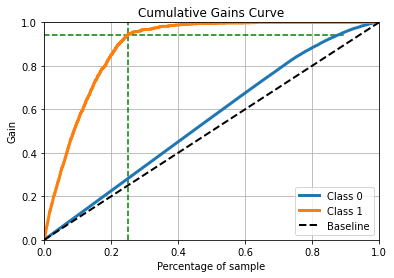

In [87]:
plot_gain_curve(y_test, y_test_pred_prob, x=0.25, y=0.94)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 25% of the leads we can acheive 94% of the conversion rate.

In [88]:
metrics['RF'] = dict()
metrics['RF']['accuracy'] = acc
metrics['RF']['auc'] = roc_auc
metrics['RF']['prec'] = prec
metrics['RF']['recal'] = rec
metrics['RF']['f1'] = f1
metrics['RF']['lift'] = lift_index

#### 6.6 XGBoost Classifier

In [70]:
%%time
# max_depth, min_samples_split, min_samples_leaf
params = {'n_estimators':[200], 'max_depth': [9, 10], 
          'learning_rate': [0.01, 0.1], 'colsample_bytree': [0.8, 0.9]}

xgb_clf = XGBClassifier(scale_pos_weight=0.88, random_state=10)

grid_xgb_CV = GridSearchCV(xgb_clf, params, scoring='f1', cv=5, verbose=4, n_jobs=-1)
grid_xgb_CV.fit(X_train_final, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:40:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 32.1 s, sys: 161 ms, total: 32.3 s
Wall time: 1h 48min 45s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=10,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=0.88, subsample=None,
                                     tree_method=None, v

In [72]:
print('Best F1 score for XGB Classifier: ', grid_xgb_CV.best_score_)
print('Best Params for XGB Classifier: ', grid_xgb_CV.best_params_)

Best F1 score for XGB Classifier:  0.5677756672076321
Best Params for XGB Classifier:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200}


In [89]:
xgb_clf = XGBClassifier(n_estimators = 200, 
                        max_depth = 10, 
                        learning_rate = 0.1, 
                        colsample_bytree = 0.9, 
                        scale_pos_weight=0.88, random_state=10)

xgb_clf.fit(X_train_final, y_train)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:15:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.88, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

##### 6.6.1 Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.9149484536082474


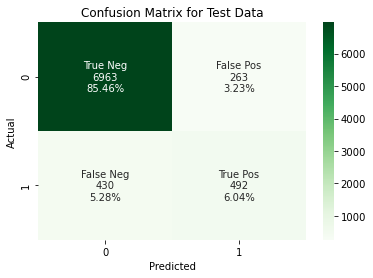

In [90]:
y_test_pred, acc = print_confusion_matrix_accuracy(xgb_clf, X_test_final, y_test)

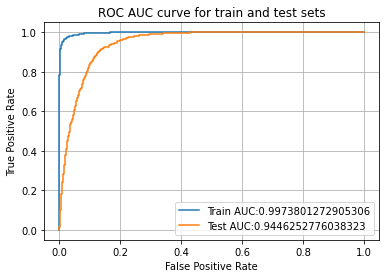

In [91]:
y_train_pred_prob, y_test_pred_prob, roc_auc = plot_auc(xgb_clf, X_train_final, X_test_final, y_train, y_test)

In [92]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.9418368727174354 and class-1:  0.6516556291390728
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.9636036534735677 and class-1: 0.5336225596529284
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.9525959367945824 and class-1: 0.5867620751341681


In [93]:
lift_index = get_lift_index(y_test, y_test_pred_prob)
lift_index

0.9387201735357916

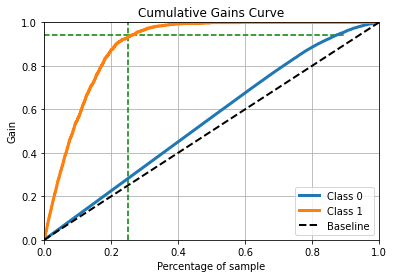

In [94]:
plot_gain_curve(y_test, y_test_pred_prob, x=0.25, y=0.94)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 25% of the leads we can acheive 94% of the conversion rate.

In [95]:
metrics['XGB'] = dict()
metrics['XGB']['accuracy'] = acc
metrics['XGB']['auc'] = roc_auc
metrics['XGB']['prec'] = prec
metrics['XGB']['recal'] = rec
metrics['XGB']['f1'] = f1
metrics['XGB']['lift'] = lift_index

#### 6.7 CatBoost Classifier

In [93]:
%%time
# max_depth, min_samples_split, min_samples_leaf
params = {'iterations':[50, 100], 'depth': [8, 9, 10], 
          'learning_rate': [0.01, 0.1]}

cat_clf = CatBoostClassifier(scale_pos_weight=0.88, random_state=10)

grid_cat_CV = GridSearchCV(cat_clf, params, scoring='f1', cv=5, verbose=4, n_jobs=-1)
grid_cat_CV.fit(X_train_final, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0:	learn: 0.5311761	total: 103ms	remaining: 10.2s
1:	learn: 0.4176294	total: 148ms	remaining: 7.25s
2:	learn: 0.3654199	total: 193ms	remaining: 6.24s
3:	learn: 0.3137351	total: 240ms	remaining: 5.75s
4:	learn: 0.2756406	total: 285ms	remaining: 5.41s
5:	learn: 0.2498439	total: 332ms	remaining: 5.21s
6:	learn: 0.2335297	total: 378ms	remaining: 5.03s
7:	learn: 0.2168824	total: 423ms	remaining: 4.86s
8:	learn: 0.2058490	total: 469ms	remaining: 4.75s
9:	learn: 0.1954356	total: 517ms	remaining: 4.65s
10:	learn: 0.1898136	total: 562ms	remaining: 4.55s
11:	learn: 0.1834791	total: 608ms	remaining: 4.46s
12:	learn: 0.1806543	total: 657ms	remaining: 4.39s
13:	learn: 0.1782945	total: 702ms	remaining: 4.32s
14:	learn: 0.1756504	total: 747ms	remaining: 4.23s
15:	learn: 0.1734603	total: 793ms	remaining: 4.16s
16:	learn: 0.1714876	total: 837ms	remaining: 4.08s
17:	learn: 0.1692754	total: 885ms	remaining: 4.03s
18:	learn: 0.1665770	total: 932

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fa62f4f2a50>,
             n_jobs=-1,
             param_grid={'depth': [8, 9, 10], 'iterations': [50, 100],
                         'learning_rate': [0.01, 0.1]},
             scoring='f1', verbose=4)

In [95]:
print('Best F1 score for CatBoost Classifier: ', grid_cat_CV.best_score_)
print('Best Params for CatBoost Classifier: ', grid_cat_CV.best_params_)

Best F1 score for CatBoost Classifier:  0.5555831108019536
Best Params for CatBoost Classifier:  {'depth': 10, 'iterations': 100, 'learning_rate': 0.1}


In [121]:
cat_clf = CatBoostClassifier(depth=10, iterations=100, learning_rate=0.1,
                                class_weights=[0.12, 0.88], random_state=10, silent=True)

cat_clf.fit(X_train_final, y_train)

##### 6.7.1 Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.8832842415316642


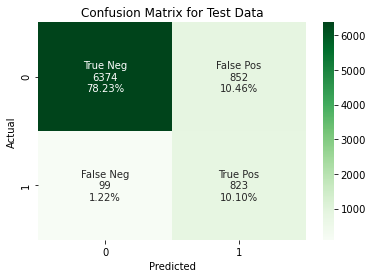

In [113]:
y_test_pred, acc = print_confusion_matrix_accuracy(cat_clf, X_test_final, y_test)

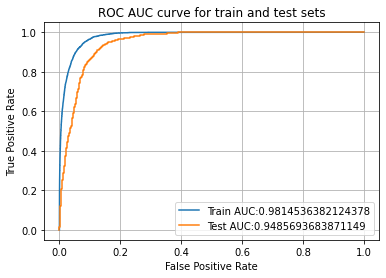

In [114]:
y_train_pred_prob, y_test_pred_prob, roc_auc = plot_auc(cat_clf, X_train_final, X_test_final, y_train, y_test)

In [115]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.9847057006025027 and class-1:  0.49134328358208956
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.8820924439523942 and class-1: 0.8926247288503254
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.930578874370392 and class-1: 0.6338082402772429


In [116]:
lift_index = get_lift_index(y_test, y_test_pred_prob)
lift_index

0.9398047722342733

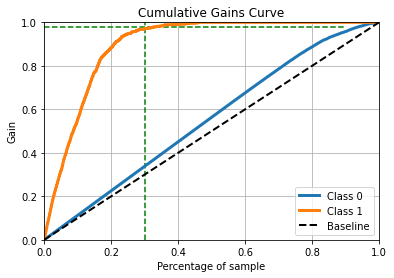

In [117]:
plot_gain_curve(y_test, y_test_pred_prob, x=0.30, y=0.98)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 30% of the leads we can acheive 98% of the conversion rate.

In [118]:
metrics['CAT'] = dict()
metrics['CAT']['accuracy'] = acc
metrics['CAT']['auc'] = roc_auc
metrics['CAT']['prec'] = prec
metrics['CAT']['recal'] = rec
metrics['CAT']['f1'] = f1
metrics['CAT']['lift'] = lift_index

#### 6.8 LGBM Classifier

In [105]:
%%time
# max_depth, min_samples_split, min_samples_leaf
params = {'num_iterations':[50, 100], 'max_depth': [8, 9, 10]} #, 'num_leaves': [256, 512, 1024]

lgbm_clf = LGBMClassifier(class_weight='balanced', random_state=10)

grid_lgbm_CV = GridSearchCV(lgbm_clf, params, scoring='f1', cv=5, verbose=4, n_jobs=-1)
grid_lgbm_CV.fit(X_train_final, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 2.29 s, sys: 100 ms, total: 2.39 s
Wall time: 39min 42s


GridSearchCV(cv=5,
             estimator=LGBMClassifier(class_weight='balanced', random_state=10),
             n_jobs=-1,
             param_grid={'max_depth': [8, 9, 10], 'num_iterations': [50, 100]},
             scoring='f1', verbose=4)

In [106]:
print('Best F1 score for CatBoost Classifier: ', grid_lgbm_CV.best_score_)
print('Best Params for CatBoost Classifier: ', grid_lgbm_CV.best_params_)

Best F1 score for CatBoost Classifier:  0.6064794575852617
Best Params for CatBoost Classifier:  {'max_depth': 10, 'num_iterations': 100}


In [103]:
lgbm_clf = LGBMClassifier(num_iterations=100, max_depth=10, class_weight='balanced', random_state=10)

lgbm_clf.fit(X_train_final, y_train)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(class_weight='balanced', max_depth=10, num_iterations=100,
               random_state=10)

##### 6.8.1 Performance Analysis - Confusion matrix, Accuracy, AUC, F1 Score, LIFT

Model Accuracy:  0.872852233676976


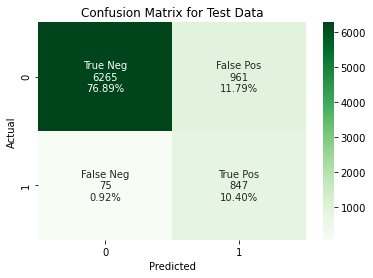

In [104]:
y_test_pred, acc = print_confusion_matrix_accuracy(lgbm_clf, X_test_final, y_test)

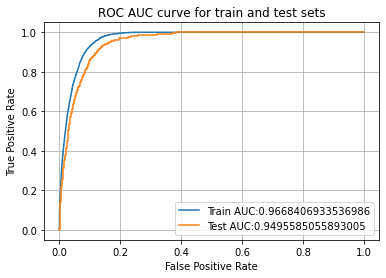

In [105]:
y_train_pred_prob, y_test_pred_prob, roc_auc = plot_auc(lgbm_clf, X_train_final, X_test_final, y_train, y_test)

In [106]:
prec, rec, f1 = precision_recall_f1(y_test, y_test_pred)

Precision Score for class-0: 0.9881703470031545 and class-1:  0.4684734513274336
----------------------------------------------------------------------------------------------------
Recall Score for class-0: 0.8670080265707168 and class-1: 0.9186550976138829
----------------------------------------------------------------------------------------------------
F1 Score for class-0: 0.9236326109391125 and class-1: 0.6205128205128205


In [107]:
lift_index = get_lift_index(y_test, y_test_pred_prob)
lift_index

0.9429501084598697

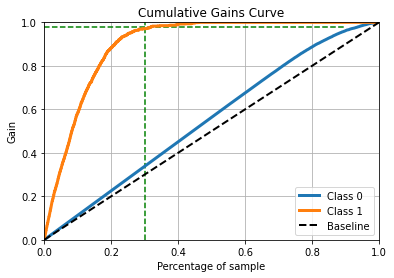

In [108]:
plot_gain_curve(y_test, y_test_pred_prob, x=0.30, y=0.98)

* From the above cumulative gain curve...
    * Orange curve represents the cumulative gain for positive class.
    * A green horizontal and vertical dashed lines are plotted to denote the point where gain curve begins to platue
    * This intersection point tells us, with only 30% of the leads we can acheive 98% of the conversion rate.

In [109]:
metrics['LGBM'] = dict()
metrics['LGBM']['accuracy'] = acc
metrics['LGBM']['auc'] = roc_auc
metrics['LGBM']['prec'] = prec
metrics['LGBM']['recal'] = rec
metrics['LGBM']['f1'] = f1
metrics['LGBM']['lift'] = lift_index

## 7. Summary

In [119]:
from tabulate import tabulate
heads = ['Classifier', 'Accuracy', 'AUC', 'Precision', 'Recall', 'F1_Score', 'Lift Index']

data_table = []
for clf in metrics:
    # print(clf, "====", metric, "====", metrics[clf][metric])
    data_table.append([clf, metrics[clf]['accuracy'], metrics[clf]['auc'], metrics[clf]['prec'][1], 
                       metrics[clf]['recal'][1], metrics[clf]['f1'][1], metrics[clf]['lift']])

print(tabulate(data_table, heads, tablefmt='orgtbl'))

| Classifier   |   Accuracy |      AUC |   Precision |   Recall |   F1_Score |   Lift Index |
|--------------+------------+----------+-------------+----------+------------+--------------|
| LR           |   0.860211 | 0.935894 |    0.440936 | 0.878525 |   0.587169 |     0.932321 |
| NB           |   0.87187  | 0.830369 |    0.44043  | 0.489154 |   0.463515 |     0.838612 |
| SVC          |   0.851865 | 0.93675  |    0.427921 | 0.91757  |   0.58365  |     0.93308  |
| DT           |   0.850393 | 0.9323   |    0.425189 | 0.915401 |   0.580667 |     0.92256  |
| RF           |   0.859229 | 0.940897 |    0.441437 | 0.91974  |   0.596553 |     0.934599 |
| XGB          |   0.914948 | 0.944625 |    0.651656 | 0.533623 |   0.586762 |     0.93872  |
| CAT          |   0.883284 | 0.948569 |    0.491343 | 0.892625 |   0.633808 |     0.939805 |
| LGBM         |   0.872852 | 0.949559 |    0.468473 | 0.918655 |   0.620513 |     0.94295  |


* Above table is the comparison of the metrics after hyper parameter tuning. 

* Accuracy, AUC, F1 score and Lift index are at their best for LGBM classifier.
* Precision has best value in LR
* Recall has best value in DT

* Above is the performance of basic classifiers without any hyper parameter tuning. 